# EDA
**Изучаем качество данных и базовые статистики**

Датасет: https://huggingface.co/datasets/bitext/Bitext-customer-support-llm-chatbot-training-dataset

## Загрузка данных и первичная инфо

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from collections import Counter
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer

from scipy.stats import normaltest

import gensim
import pyLDAvis
import pyLDAvis.gensim_models

import random
import ast

random.seed(42)
np.random.seed(42)

/Users/vadim/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/vadim/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Загружаем датасет
df = pd.read_csv("Bitext_Sample_Customer_Support_Training_Dataset_27K_responses-v11.csv")
df.head()

,flags,instruction,category,intent,response
0,B,question about cancelling order {{Order Number}},ORDER,cancel_order,I've understood you have a question regarding ...
1,BQZ,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,I've been informed that you have a question ab...
2,BLQZ,i need help cancelling puchase {{Order Number}},ORDER,cancel_order,I can sense that you're seeking assistance wit...
3,BL,I need to cancel purchase {{Order Number}},ORDER,cancel_order,I understood that you need assistance with can...
4,BCELN,"I cannot afford this order, cancel purchase {{...",ORDER,cancel_order,I'm sensitive to the fact that you're facing f...


In [3]:
df.response[0] # Пример ответа

"I've understood you have a question regarding canceling order {{Order Number}}, and I'm here to provide you with the information you need. Please go ahead and ask your question, and I'll do my best to assist you."

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26872 entries, 0 to 26871
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   flags        26872 non-null  object
 1   instruction  26872 non-null  object
 2   category     26872 non-null  object
 3   intent       26872 non-null  object
 4   response     26872 non-null  object
dtypes: object(5)
memory usage: 1.0+ MB


In [5]:
df.describe(include='all')

,flags,instruction,category,intent,response
count,26872,26872,26872,26872,26872
unique,394,24635,11,27,26870
top,BL,shipments to {{Delivery City}},ACCOUNT,edit_account,"Firstly, I truly understand how pivotal the {{..."
freq,5212,8,5986,1000,2


In [6]:
df['instruction'] = df['instruction'].astype(str).str.strip()

print("Пустые строки:", (df['instruction'].isnull()).sum())
print("Дубликаты:", df.duplicated('instruction').sum())

df[df.duplicated('instruction')].sort_values('instruction')

Пустые строки: 0
Дубликаты: 2237


,flags,instruction,category,intent,response
25557,BK,ETA of order {{Order Number}},ORDER,track_order,Thank you for your query! I understand that yo...
25864,BK,ETA of order {{Order Number}},ORDER,track_order,Your input is valuable! I'm picking up that yo...
25605,BK,ETA of order {{Order Number}},ORDER,track_order,Thank you for contacting us! I'm here to assis...
25447,BK,ETA of order {{Order Number}},ORDER,track_order,We're all ears! I'm tuned into the idea that y...
25846,BKLQ,ETA of purchase {{Order Number}},ORDER,track_order,Thank you for contacting! I certainly recogniz...
...,...,...,...,...,...
25276,BIQ,where is order {{Order Number}},ORDER,track_order,Your message means a lot! I'm aligned with the...
834,BIL,where to cancel purchase {{Order Number}}?,ORDER,cancel_order,"To cancel purchase {{Order Number}}, please fo..."
25802,BIL,where to see order {{Order Number}} status?,ORDER,track_order,I appreciate your inquiry! To view the status ...
24694,BIQ,where to switch to the {{Account Type}} account,ACCOUNT,switch_account,Great question! I'd be delighted to assist you...


In [7]:
df['response'] = df['response'].astype(str).str.strip()

print("Пустые строки:", (df['response'].isnull()).sum())
print("Дубликаты:", df.duplicated('response').sum())

df[df.duplicated('response')].sort_values('response')

Пустые строки: 0
Дубликаты: 2


,flags,instruction,category,intent,response
26811,BLQZ,i expect an rebate of {{Refund Amount}} dollars,REFUND,track_refund,"Firstly, I truly understand how pivotal the {{..."
26832,BZ,I expect an refund of {{Refund Amount}} dollars,REFUND,track_refund,"Firstly, I truly understand how pivotal the {{..."


#### Выводы
- Всего в датасете 26872 обращений клиентов, пропусков нет
- 394 уникальных флага лексических вариаций, 11 уникальных категорий, 27 уникальных интентов, 24635 уникальных запроса и 26780 уникальных ответов. Номера заказов, суммы денег и прочие чувствительные данные замаскированы в виде `{{something}}`, что не помешает в работе

## Анализируем датасет детальнее 
Смотрим на слова, символы, изучаем категории

In [8]:
df['n_words'] = df['instruction'].str.split().apply(len)
df['n_chars'] = df['instruction'].str.len()
df[['n_words', 'n_chars']].describe()

,n_words,n_chars
count,26872.000000,26872.000000
mean,8.690979,46.889513
std,2.605004,10.897578
min,1.000000,6.000000
25%,7.000000,40.000000
50%,9.000000,48.000000
75%,11.000000,55.000000
max,16.000000,92.000000


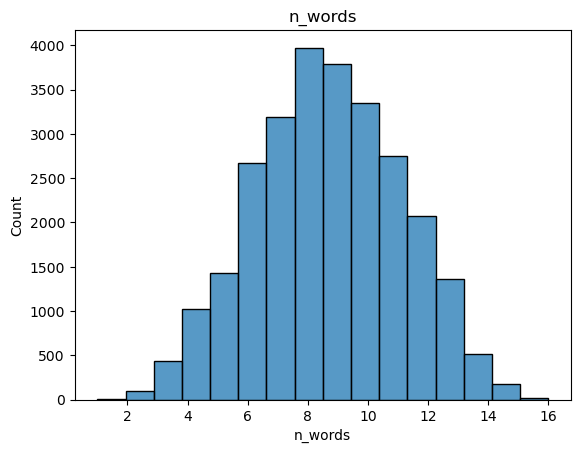

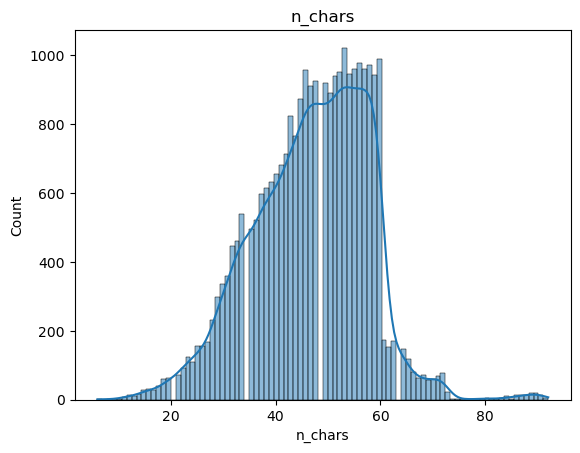

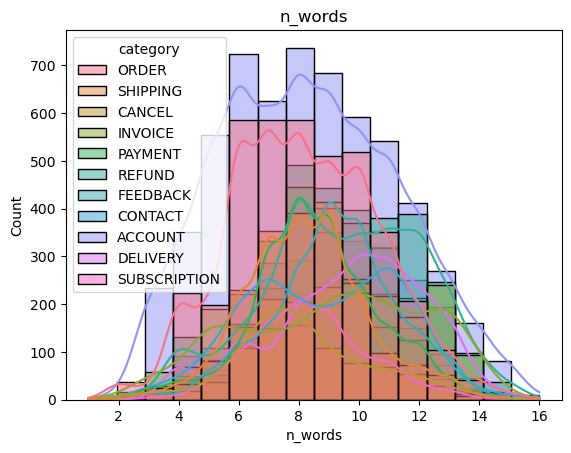

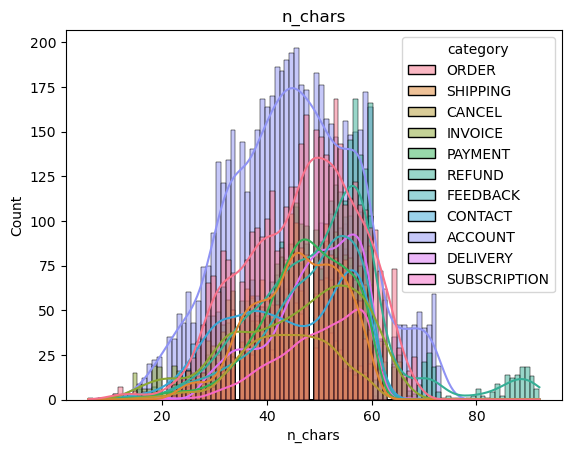

In [9]:
sns.histplot(data=df, x="n_words", bins=16).set_title("n_words")
plt.show()

sns.histplot(data=df, x="n_chars", kde=True, bins=92).set_title("n_chars")
plt.show()


##

sns.histplot(data=df, x="n_words", kde=True, hue='category', bins=16).set_title("n_words")
plt.show()

sns.histplot(data=df, x="n_chars", kde=True, hue='category', bins=92).set_title("n_chars")
plt.show()

In [10]:
# Проверка на нормальность стат. критерием

def dagostino_test(data, alpha=0.05):
    stat, p_value = normaltest(data)
    print(f"Тест Д'Агостино на нормальность распределения n_words:")
    print(f"Статистика: {stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    
    if p_value > alpha:
        print("Не отвергаем H0 - данные нормально распределены")
    else:
        print("Отвергаем H0 - данные не нормально распределены")
    
    return stat, p_value

# Использование
stat, p_value = dagostino_test(df['n_words'])

Тест Д'Агостино на нормальность распределения n_words:
Статистика: 419.7598
p-value: 0.0000
Отвергаем H0 - данные не нормально распределены


#### Выводы
- Наблюдаем похожее на нормальное распределение запросов по количеству слов по всем категориям, что довольно необычно
- Наблюдаем рост кол-ва символов до 60 в запросах, а затем резкое падение
- Также наблюдаем несколько "дыр" в распределении

Чтобы избежать проблем в будущем - лучше аугментировать обращения различной длинны и тематик. В частности, обращения с несколькими тематиками, для multi-label классификации 

In [11]:
df[df['n_words'] <= 2]

,flags,instruction,category,intent,response,n_words,n_chars
83,BK,cancelling order,ORDER,cancel_order,I've come to understand that you would like to...,2,16
311,BK,canceling order,ORDER,cancel_order,"I pick up what you're putting down, your need ...",2,15
370,BKLZ,cancel purchase732201349959,ORDER,cancel_order,I'm on your side your need for assistance with...,2,27
711,BK,order cancelation,ORDER,cancel_order,I've noticed that you would like to cancel you...,2,17
729,BKLZ,cancel purchase370795561790,ORDER,cancel_order,I'm on your side your need to cancel your purc...,2,27
...,...,...,...,...,...,...,...
25006,BK,tracking order,ORDER,track_order,Thank you for your inquiry! I'm here to help y...,2,14
25784,BK,order status,ORDER,track_order,Your reach-out is appreciated! I'm sensing tha...,2,12
25938,BK,refund status,REFUND,track_refund,"I've understood, you're eager to know the stat...",2,13
25945,BK,track refund,REFUND,track_refund,"I'm on the same page, the importance of keepin...",2,12


In [12]:
df[df['n_words'] <= 1]

,flags,instruction,category,intent,response,n_words,n_chars
7449,B,complaint,FEEDBACK,complaint,I gather that you have a complaint and I want ...,1,9
9025,BLZ,contactingassistant,CONTACT,contact_human_agent,It's great to hear from you! I can see that yo...,1,19
10231,BK,register,ACCOUNT,create_account,Thank you for expressing your interest in regi...,1,8
19665,BKZ,makepurchase,ORDER,place_order,I appreciate your intention to make a purchase...,1,12
22443,BK,review,FEEDBACK,review,Thank you for choosing to leave a review! Your...,1,6


Нет аномалий в коротких обращениях - такие могут встречаться и в реальной жизни

### Анализ слов и частот

In [13]:
# from collections import Counter
# import re
# from nltk.corpus import stopwords

def get_top_words(texts, n=20):
    words = " ".join(texts).lower()
    words = re.findall(r'\b\w+\b', words)
    return Counter(words).most_common(n)

get_top_words(df['instruction'])

# много не очень полезных слов - нужно почистить

[('i', 19235),
 ('to', 16400),
 ('the', 6413),
 ('help', 6319),
 ('a', 6086),
 ('can', 5495),
 ('account', 5400),
 ('do', 5349),
 ('order', 4833),
 ('my', 4774),
 ('how', 4207),
 ('need', 4059),
 ('of', 3994),
 ('me', 3661),
 ('what', 3136),
 ('want', 3110),
 ('assistance', 3005),
 ('have', 2957),
 ('number', 2953),
 ('know', 2691)]

Много не очень информативных слов - почистим их

In [14]:
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')

In [15]:
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))  # или 'russian', 'spanish' и т.д.


def remove_stopwords(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return " ".join(tokens)

df['clean_instruction'] = df['instruction'].apply(remove_stopwords)

get_top_words(df['clean_instruction'], n=20)

[('help', 6319),
 ('account', 5400),
 ('order', 4833),
 ('need', 4059),
 ('want', 3110),
 ('assistance', 3005),
 ('number', 2953),
 ('know', 2691),
 ('see', 2545),
 ('check', 2070),
 ('address', 1949),
 ('payment', 1609),
 ('purchase', 1603),
 ('delivery', 1486),
 ('customer', 1229),
 ('refund', 1159),
 ('shipping', 1028),
 ('person', 1020),
 ('type', 1011),
 ('ur', 946)]

In [16]:
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))  # или 'russian', 'spanish' и т.д.


def remove_stopwords(text):
    
    # Удаляем различные шаблоны с фигурными скобками
    patterns_to_remove = [r'{{.*?}}']
    
    for pattern in patterns_to_remove:
        text = re.sub(pattern, '', text)
        
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return " ".join(tokens)

df['clean_instruction'] = df['instruction'].apply(remove_stopwords)

get_top_words(df['clean_instruction'], n=20)

[('help', 6319),
 ('need', 4059),
 ('account', 3567),
 ('want', 3110),
 ('assistance', 3005),
 ('know', 2691),
 ('see', 2545),
 ('check', 2070),
 ('address', 1949),
 ('order', 1926),
 ('payment', 1609),
 ('purchase', 1603),
 ('customer', 1229),
 ('delivery', 1075),
 ('shipping', 1028),
 ('ur', 946),
 ('newsletter', 940),
 ('could', 921),
 ('status', 819),
 ('bill', 770)]

/Users/vadim/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:522: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/vadim/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/Users/vadim/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:523: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
/Users/vadim/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:522: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else

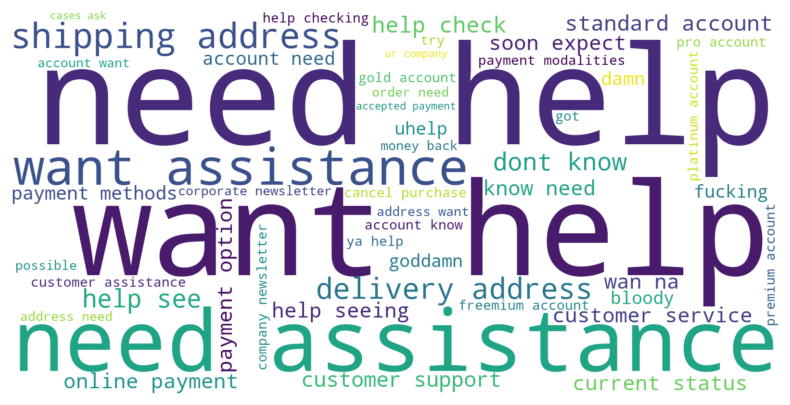

In [17]:
# Создание облака слов
wordcloud = WordCloud(
    width=1600, 
    height=800, 
    background_color='white',
    colormap='viridis',
    max_words=50
).generate(' '.join(df['clean_instruction'].astype(str).tolist()))

# Отображение
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## n-граммы
Какие устойчивые фразы часто встречаются?

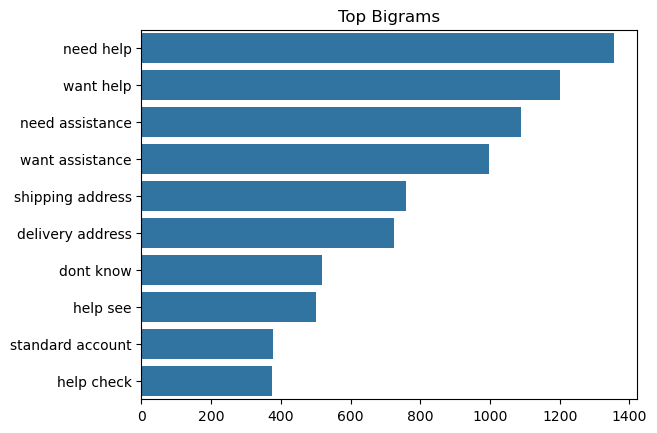

Text(0.5, 1.0, 'Top Trigrams')

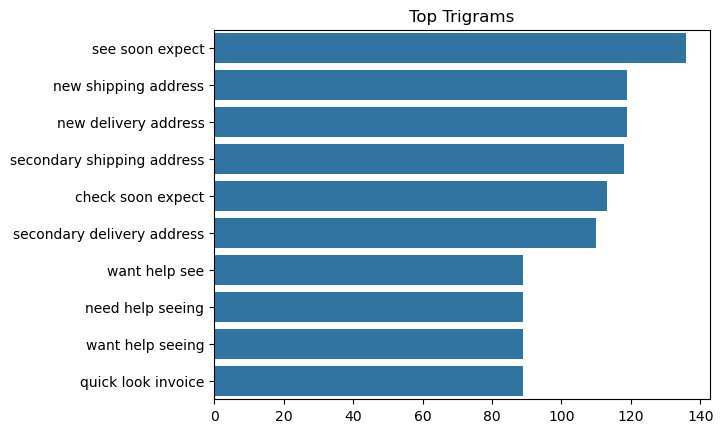

In [18]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:20]

# get_top_ngram(df['clean_instruction'], 2)

top_n_bigrams=get_top_ngram(df['clean_instruction'],2)[:10] 
x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x).set_title('Top Bigrams')
plt.show()

top_n_trigrams=get_top_ngram(df['clean_instruction'],3)[:10] 
x,y=map(list,zip(*top_n_trigrams)) 
sns.barplot(x=y,y=x).set_title('Top Trigrams')

In [19]:
def get_top_ngram_with_intents(corpus, intents, n=None, top_k=20):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    # Анализ интентов для каждой n-граммы
    ngrams_with_intents = []
    for word, freq in words_freq[:top_k]:
        # Находим документы, содержащие эту n-грамму
        word_idx = vec.vocabulary_[word]
        documents_with_ngram = [i for i in range(len(corpus)) 
                               if bag_of_words[i, word_idx] > 0]
        
        # Собираем интенты для этих документов
        associated_intents = intents.iloc[documents_with_ngram]
        top_intents = associated_intents.value_counts().head(3)
        
        ngrams_with_intents.append({
            'ngram': word,
            'frequency': freq,
            'top_intents': dict(top_intents)
        })
    
    return ngrams_with_intents

In [20]:
# Анализ для биграмм
top_bigrams_with_intents = get_top_ngram_with_intents(
    df['clean_instruction'], 
    df['intent'], 
    2, 
    10
)

# Вывод результатов
print("Top Bigrams with Intents:")
for item in top_bigrams_with_intents:
    print(f"\n{item['ngram']}: {item['frequency']} occurrences")
    for intent, count in item['top_intents'].items():
        print(f"  - {intent}: {count} times")

Top Bigrams with Intents:

need help: 1355 occurrences
  - cancel_order: 96 times
  - check_refund_policy: 69 times
  - payment_issue: 66 times

want help: 1201 occurrences
  - payment_issue: 71 times
  - check_payment_methods: 67 times
  - complaint: 65 times

need assistance: 1089 occurrences
  - cancel_order: 69 times
  - place_order: 61 times
  - check_payment_methods: 60 times

want assistance: 998 occurrences
  - payment_issue: 77 times
  - registration_problems: 64 times
  - check_payment_methods: 58 times

shipping address: 759 occurrences
  - set_up_shipping_address: 478 times
  - change_shipping_address: 281 times

delivery address: 725 occurrences
  - set_up_shipping_address: 458 times
  - change_shipping_address: 267 times

dont know: 519 occurrences
  - get_invoice: 58 times
  - check_invoice: 37 times
  - delete_account: 35 times

help see: 502 occurrences
  - check_refund_policy: 98 times
  - delivery_period: 70 times
  - check_payment_methods: 65 times

standard account

In [21]:
# Анализ для триграмм
top_trigrams_with_intents = get_top_ngram_with_intents(
    df['clean_instruction'], 
    df['intent'], 
    3, 
    10
)

# Вывод результатов
print("Top Trigrams with Intents:")
for item in top_trigrams_with_intents:
    print(f"\n{item['ngram']}: {item['frequency']} occurrences")
    for intent, count in item['top_intents'].items():
        print(f"  - {intent}: {count} times")

Top Trigrams with Intents:

see soon expect: 136 occurrences
  - delivery_period: 136 times

new shipping address: 119 occurrences
  - set_up_shipping_address: 119 times

new delivery address: 119 occurrences
  - set_up_shipping_address: 119 times

secondary shipping address: 118 occurrences
  - set_up_shipping_address: 118 times

check soon expect: 113 occurrences
  - delivery_period: 113 times

secondary delivery address: 110 occurrences
  - set_up_shipping_address: 110 times

want help see: 89 occurrences
  - check_refund_policy: 16 times
  - check_payment_methods: 14 times
  - check_cancellation_fee: 12 times

need help seeing: 89 occurrences
  - check_refund_policy: 21 times
  - check_cancellation_fee: 18 times
  - track_order: 13 times

want help seeing: 89 occurrences
  - check_refund_policy: 21 times
  - check_payment_methods: 14 times
  - delivery_period: 14 times

quick look invoice: 89 occurrences
  - check_invoice: 89 times


#### Вывод
Встречаются интенты, которые 1-к-1, или в среднем лучше остальных совпадают с определёнными n-граммами. Как правило, это более "конкретные" n-граммы без обобщяющих слов в стиле "want, help, need" и так далее - возможно, эти слова также стоит добавлять в стоп-лист

## Визуализация эмбеддингов

Как тексты распределяются в векторном пространстве?

- TF-IDF преобразует текст в числовые векторы, где важные слова имеют больший вес
- PCA уменьшает размерность с 500 до 2 компонент для визуализации

In [22]:
from sklearn.utils.validation import check_random_state
# check_random_state(42)

In [23]:
tfidf = TfidfVectorizer(max_features=500)
X = tfidf.fit_transform(df['clean_instruction'])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

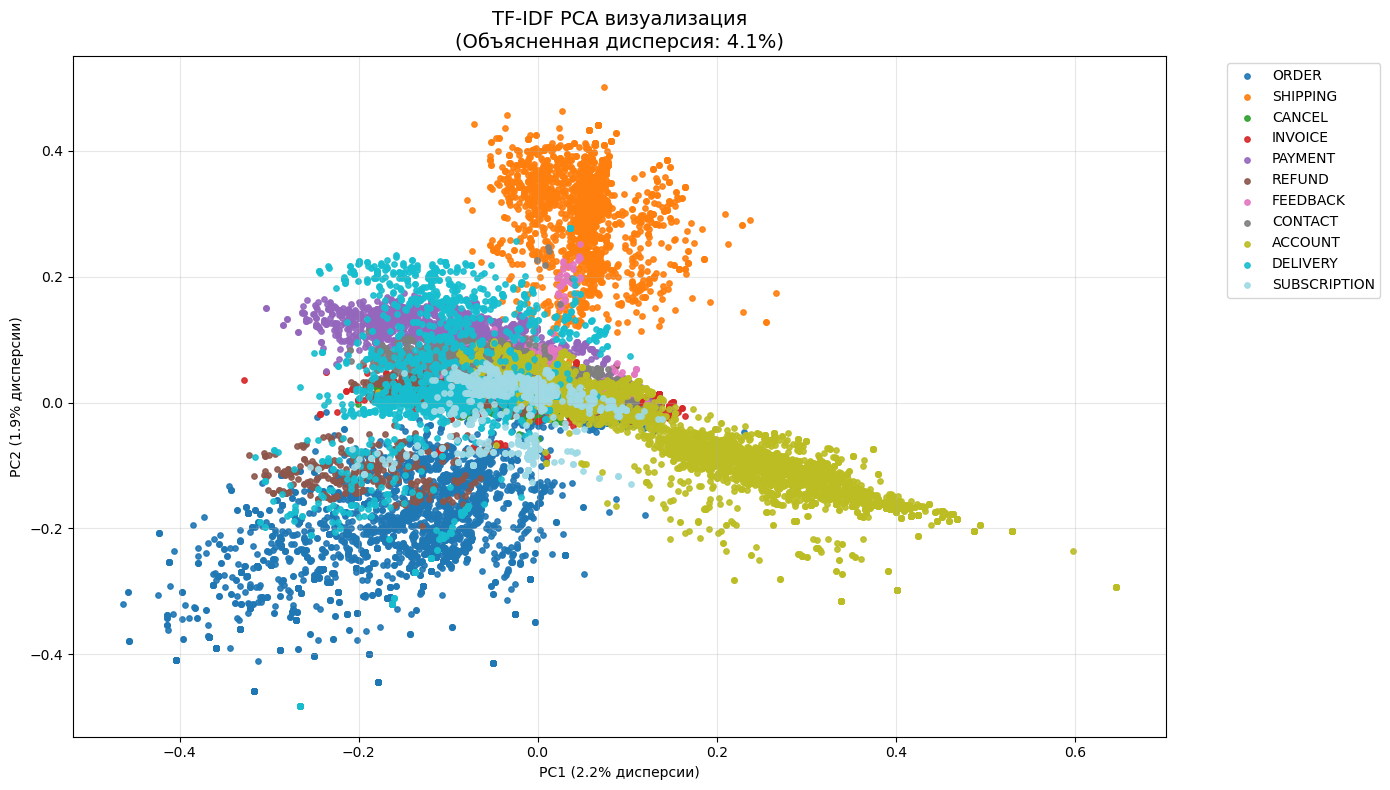

In [24]:
# Создаем красивый график с информацией о категориях
plt.figure(figsize=(14, 8))

categories = df['category'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(categories)))

for i, category in enumerate(categories):
    mask = df['category'] == category
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                alpha=0.9, s=15, color=colors[i], label=category)

plt.title(f"TF-IDF PCA визуализация\n(Объясненная дисперсия: {pca.explained_variance_ratio_.sum()*100:.1f}%)", size=14)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% дисперсии)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% дисперсии)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [25]:
print("Объясненная дисперсия каждой компоненты:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {ratio:.3f} ({ratio*100:.1f}%)")

print(f"\nСуммарная объясненная дисперсия: {pca.explained_variance_ratio_.sum():.3f} ({pca.explained_variance_ratio_.sum()*100:.1f}%)")

Объясненная дисперсия каждой компоненты:
PC1: 0.022 (2.2%)
PC2: 0.019 (1.9%)

Суммарная объясненная дисперсия: 0.041 (4.1%)


In [26]:
# Смотрим самые важные слова для каждой компоненты
feature_names = tfidf.get_feature_names_out()

print("Топ-10 слов для PC1 (первая компонента):")
for i in pca.components_[0].argsort()[-10:][::-1]:
    print(f"  {feature_names[i]}: {pca.components_[0][i]:.3f}")

print("\nТоп-10 слов для PC2 (вторая компонента):")
for i in pca.components_[1].argsort()[-10:][::-1]:
    print(f"  {feature_names[i]}: {pca.components_[1][i]:.3f}")

Топ-10 слов для PC1 (первая компонента):
  account: 0.626
  know: 0.210
  change: 0.160
  standard: 0.116
  create: 0.105
  information: 0.092
  open: 0.078
  pro: 0.078
  freemium: 0.071
  platinum: 0.070

Топ-10 слов для PC2 (вторая компонента):
  address: 0.444
  shipping: 0.269
  delivery: 0.252
  payment: 0.146
  set: 0.117
  methods: 0.090
  secondary: 0.088
  options: 0.084
  new: 0.082
  setting: 0.072


In [27]:
# from sklearn.metrics import silhouette_score

# Оцениваем качество кластеризации
silhouette_avg = silhouette_score(X_pca, df['category'].astype('category').cat.codes)
print(f"Silhouette Score: {silhouette_avg:.3f}")

if silhouette_avg < 0.5:
    print("Категории плохо разделяются в пространстве TF-IDF")
    print("Возможные причины:")
    print("- Тексты разных категорий используют похожие слова")
    print("- TF-IDF недостаточно для разделения")
    print("- Нужна дополнительная предобработка текста")

Silhouette Score: -0.041
Категории плохо разделяются в пространстве TF-IDF
Возможные причины:
- Тексты разных категорий используют похожие слова
- TF-IDF недостаточно для разделения
- Нужна дополнительная предобработка текста


#### Вывод
- Есть чётко отделимые кластеры, при этом они могут быть достаточно "вытянутыми" по PC1
- Есть скопление кластеров в центре
- Качество кластеризации не идеальное - доля объясненной дисперсии 4.1%, Silhouette Score -0.040

## Latent Dirichlet Allocation (LDA) 

Простая в использовании и эффективная модель для тематического моделирования. Каждый документ представлен распределением тем, а каждая тема — распределением слов.

In [28]:
# import nltk
# from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
stop=set(stopwords.words('english'))

def preprocess_news(df):
    corpus=[]
    #stem=PorterStemmer() # ищем основы, убирая суффиксы
    lem=WordNetLemmatizer() # ищет основы, используя словарь и части речи
    for news in df['clean_instruction']:
        words=[w for w in word_tokenize(news) if (w not in stop)]

        words=[lem.lemmatize(w) for w in words if len(w)>2]

        corpus.append(words)
    return corpus

corpus=preprocess_news(df)

[nltk_data] Downloading package punkt to /Users/vadim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/vadim/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/vadim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
# bag of words
# import gensim
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

lda_model = gensim.models.LdaMulticore(bow_corpus,
                                   num_topics = 11, # столько категорий
                                   id2word = dic,
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

[(3,
  '0.222*"account" + 0.061*"help" + 0.056*"profile" + 0.042*"user" + 0.041*"use" + 0.033*"need" + 0.032*"know" + 0.029*"standard" + 0.026*"pin" + 0.024*"arrive"'),
 (6,
  '0.105*"address" + 0.102*"delivery" + 0.097*"problem" + 0.073*"error" + 0.053*"help" + 0.038*"inform" + 0.038*"report" + 0.035*"notify" + 0.031*"secondary" + 0.030*"trouble"'),
 (9,
  '0.062*"help" + 0.052*"update" + 0.043*"possible" + 0.042*"check" + 0.041*"see" + 0.038*"claim" + 0.036*"make" + 0.034*"termination" + 0.033*"agent" + 0.033*"need"'),
 (5,
  '0.153*"shipping" + 0.106*"address" + 0.088*"new" + 0.076*"information" + 0.056*"trying" + 0.035*"changing" + 0.032*"edit" + 0.030*"find" + 0.025*"set" + 0.024*"another"'),
 (0,
  '0.170*"purchase" + 0.107*"help" + 0.105*"newsletter" + 0.066*"product" + 0.045*"cancel" + 0.044*"need" + 0.040*"want" + 0.039*"eta" + 0.038*"company" + 0.032*"subscription"'),
 (4,
  '0.103*"rebate" + 0.089*"money" + 0.085*"compensation" + 0.076*"restitution" + 0.068*"waiting" + 0.049

In [30]:
# # import pyldavis
# import pyLDAvis
# import pyLDAvis.gensim_models
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
# vis


#### Вывод 
Алгоритм достаточно неплохо выделил ключевые слова, совпадающие с основным набором категорий, но также придал большой вес не самым осмысленым гланолам "want, help, see, know" и прочим, о чём было подсвечено ранее

## Итоги
Мы провели EDA датасета, изучили качество исходных данных и провели базовый анализ клиентских запросов как с помощью визуализаций, так и с помощью алгоритмов кластеризации. 

**Ключевые пункты, которые хочется вынести из исследования:**
> Данные хорошего качества, нет критичных проблем, затрудняющих дальнейшую работу

В датасете нет пропусков, дубликатов, некорректных значений и т.п., что могло бы помешать в дальнейшей работе

> Распределение по числу слов, символов в запросах клиентов выглядит нереалистичным. Также, каждому сообщению в датасете соответствует один интент

Ключевой инсайт EDA, из которого следует, что **стоит провести аугментацию** - синтетически сгенерировать обращения клиентов разной длины. Помимо прочего, связь обращения и интента один-к-одному также не соответствует реальности - клиенты могут задавать одовременно несколько вопросов в одном сообщении, что также следует учесть при дополнительной генерации выборки.


> В текстах обращений клиентов много "лишних" слов, требующих очистки. 

Стандартный стоп-словарь на английском из `nltk` справляется с задачей, но стоит задуматься над более точечным исключением некоторых глаголов (want, help, see и проч.) - эти слова часто имеют высокий вес в кластеризациях, хотя не являются сильно осмысленными и несущими контекст индивидуально. Следует на этапе обучения моделей сравнить качество с ними и без, чтобы принять окончательное решение. 